In [49]:
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split




In [198]:
data1 = pd.read_csv('data/01/1_raw_data_13-12_22.03.16.txt', sep="\s+")
data2 = pd.read_csv('data/01/2_raw_data_13-13_22.03.16.txt', sep="\s+")

print(len(data1))
print(len(data2))
data = data1.append(data2, ignore_index=True)
data.head()


63196
57974


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0


In [184]:
N = 8
ch_names = []
for i in range(8):
    ch_name = 'channel' + str(i+1)
    ch_names.append(ch_name)
    print( min(data[ch_name]), max(data[ch_name]) ) 

# Values are in a slightly different range in each channel, so normalisation is preferrable


-0.00116 0.0012699999999999999
-0.0011300000000000001 0.0012699999999999999
-0.00106 0.0012699999999999999
-0.00112 0.0012699999999999999
-0.00128 0.0012699999999999999
-0.00112 0.0012699999999999999
-0.00109 0.0012699999999999999
-0.0010199999999999999 0.0012699999999999999


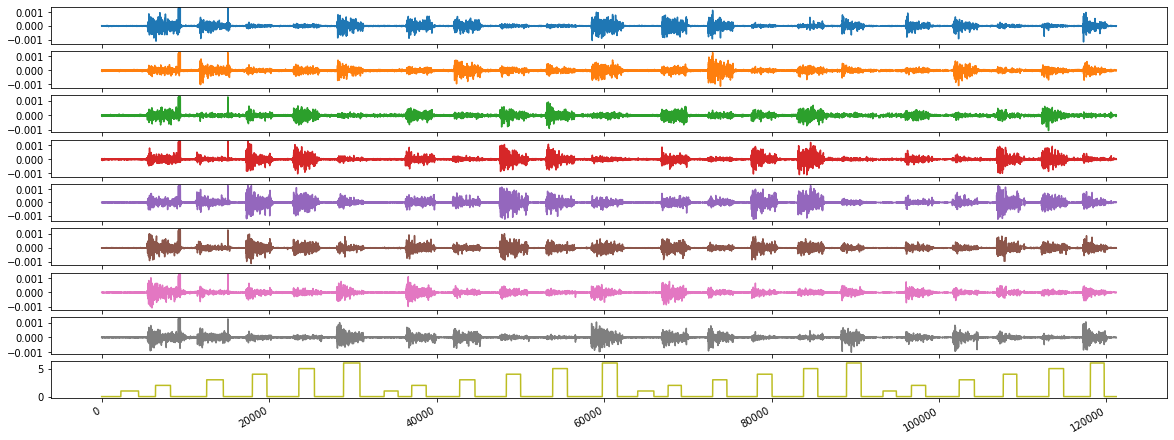

In [199]:
cols_to_plot = ch_names.copy()
cols_to_plot.append('class')
data = data[cols_to_plot]

def plot_data(data):
    data.plot(subplots=True, legend=False, figsize=(20,8))
    pyplot.show()

plot_data(data)
# Characters of the signal look different during the diverse time intervals 
# (that, presumably, correspond to the different labels)

# It looks reasonable to use an absolute value of the signal for the regression
#  because mean signal value will be around 0
#  while the set of mean amplitudes 
#  looks unique and more or less persistent for each class (except the '0' class sometimes),   
#   being the key source of information while not taking the time nature of the signal into account.

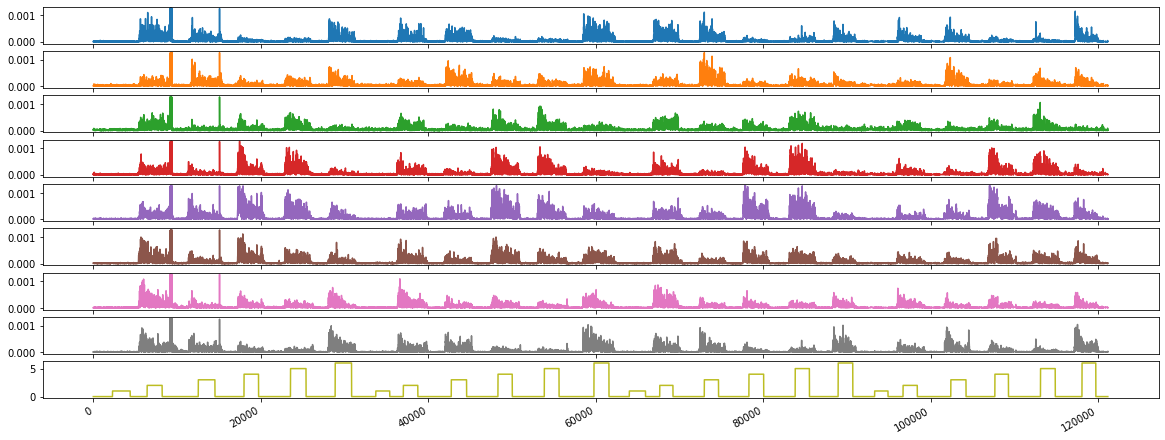

In [200]:
data = data.abs()

plot_data(data)

# We can actually see here two clips on the first two active series. 
# They rise maximum value and thus compresses a range of values for almost all of the channels
# We can discard them, because it looks like an artefact.


9160 0.0012699999999999999


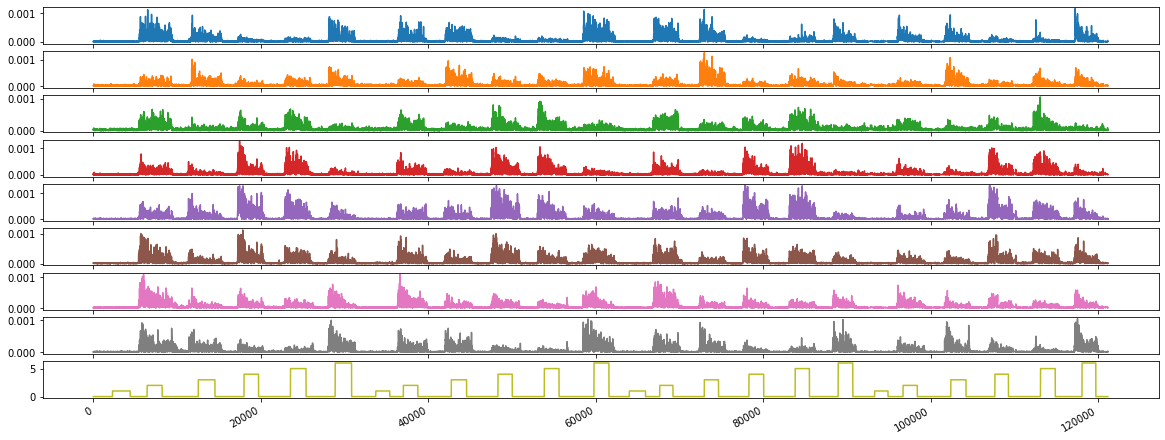

In [187]:
# using the 3d channal as 
ch3 = data["channel3"]
max_val = max(ch3)
print(ch3.argmax(), max_val)

discarding_cells = ch3 < max_val*0.9
data = data[discarding_cells]
plot_data(data)



In [188]:

def train_logistic_regression(data):
    X = data[ch_names]
    Y = data["class"]

    train_X, test_X, train_Y, test_Y = train_test_split( X, Y, test_size=0.15)

    sc = StandardScaler()
    train_X = sc.fit_transform(train_X) #rebalance?
    test_X = sc.transform(test_X)

    c1 = LogisticRegression(random_state = 42)
    c1.fit(train_X, train_Y)

    pred_Y = c1.predict(test_X)
    return test_Y, pred_Y

def print_metrics(test_Y, pred_Y):
    acc =  accuracy_score(test_Y, pred_Y)
    cm = confusion_matrix(test_Y, pred_Y)
    misclassified = (test_Y != pred_Y).sum()
    print( 'Confusion matrix:\n {}'.format(cm) )
    print( 'Misclassified Number: {}, Cardinality: {}, Accuracy: {:.2f}'.format(misclassified, len(test_Y), acc) )

In [201]:
test_Y, pred_Y = train_logistic_regression(data)
print_metrics(test_Y, pred_Y)

Confusion matrix:
 [[10999     0   201   187   187   132   130]
 [ 1069     0     0     0     0     0     0]
 [  922     0   118     0     0     0    10]
 [  884     0     0   138     0     0     5]
 [  918     0     0     0   111    14     0]
 [  963     0     0     1     3    82     0]
 [ 1037     0     5    24     0     0    36]]
Misclassified Number: 6692, Cardinality: 18176, Accuracy: 0.63


/Users/shikhu/.pyenv/versions/3.6.9/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [190]:
# Better than coin, but not very efficient
#    because of a problem class that pulls many decisions over itself. 
#    That could be seen from the plots
# The class definition 0 is marked as "unmarked data", so we actually should discard it.

# Also The class '1' ("hand at rest") is guessed correct all the time (except the false positive reactions on '0'). 
#   Presumably because of the noticeably low amplitude

print( 'Class "1" samples: {}'.format((test_Y==0).sum()) )

Class "1" samples: 11800


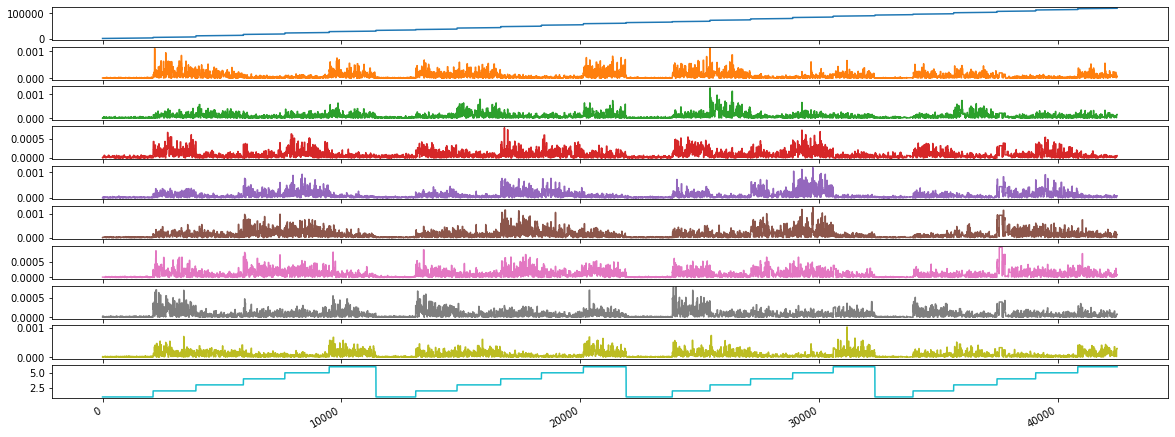

In [202]:
data = data[data["class"] != 0].reset_index()
data.head()
plot_data(data)


In [203]:
test_Y, pred_Y = train_logistic_regression(data)
print_metrics(test_Y, pred_Y)

# Most false detections are between 4 and 5 classes

Confusion matrix:
 [[1067    0    5    3    7    0]
 [   6  637   20   70  111  168]
 [  28   34  683   89   11  266]
 [  19   23   42  647  216   61]
 [  13   65   59  305  603   30]
 [   7  150  271   74   35  549]]
Misclassified Number: 2188, Cardinality: 6374, Accuracy: 0.66


/Users/shikhu/.pyenv/versions/3.6.9/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# analyse time series (batches/averages over several raws)
# Better classifier

